# To run if on Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

Mounted at /content/drive
Copying Dataset to temporary workspace...
Copied...


'/content/Dataset'

In [2]:
!pip install swifter
!pip install wordcloud
!pip install gensim
!pip install transformers
!pip install spacy
!pip install umap-learn
!spacy download en_core_web_sm

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


# Importing the Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import swifter

default_params = mpl.rcParamsDefault

import re
import time
from collections import Counter

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Pos tagging correspondence
from nltk.corpus import wordnet

# Stop words
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
# Compute bigrams.
from gensim.models import Phrases
# Utility to compute dictionary
from gensim.corpora import Dictionary

# Ner visualization
import spacy
from spacy import displacy

import torch

from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Topic Distribution with UMAP and tSNE
from yellowbrick.text import UMAPVisualizer
from yellowbrick.text import TSNEVisualizer

from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
# cleaning different patterns
def clean_tokens(tokens):
    """
    It cleans the tokens from unrelevant characters
    """
    tokens = re.sub(r"http[s]*\S+", "", tokens) #removing urls
    tokens = re.sub(r"[^\w\s'!.,]", '', tokens)
    tokens = re.sub('\d\s*star[s]?', '', tokens) # removing ratings from reviews
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens) #removing new line characters
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    tokens = re.sub(r'spoiler[s]?', '', tokens) #removing spoiler alert
    tokens = re.sub('\S*\d+\S*', '', tokens) # removing words with still numbers inside
    tokens = re.sub("(.)\\1{2,}", r"\1", tokens) #removing extra characters
    tokens = re.sub("[.,'!]\s(\b)", r"\1", tokens) #removing punctuation that was left without words
    tokens = re.sub("^[.,]\s", '', tokens) #removing punctuation at the start of the line if present
    tokens = re.sub("[.,]\s?$", '', tokens) #removing punctuation at the end of the line if present
    tokens = re.sub(r'([.,])(\S)', r'\1 \2', tokens) # adding a space after punctuation
    tokens = re.sub("(\s){1,}", r"\1", tokens) #removing extra spaces
    token = re.sub(r"\s([.,!])", r"\1", tokens) # removing spaces before punctuation
    token = re.sub(r"([.,]){1,}", r"\1", tokens) # removing extra commas and dots
    token = re.sub(r"\s('[mst])", r"\1", tokens) # removing spaces before the apostrophe
    
    return tokens.strip().lower()

In [5]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column, pos = False):
    """
    It removes the stop words from a column or an iterable of tokens, 
    the pos parameter specify if the pos is present in the iterable.
    e.g. pos == True iff [(holy, JJ), (crap, NN), (awesome, NN) <-- [0] word, [1] pos

    """

    if pos == False:
        return [[token for token in review_text if (token not in stop_words) and token.isalpha()] for review_text in column]
    else: #token[0] because it is assumed the token is the first position of the tuple
        return [[token for token in review_text if (token[0] not in stop_words) and token[0].isalpha()] for review_text in column]

In [6]:
def get_wordnet_pos(treebank_tag):
    """
    To interpret the postag to wordnet lexicon
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# EDA: Part I

## Loading the Training Set

In [7]:
df = pd.read_csv("gr_training_set.csv")

In [8]:
df.tail()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre
899995,b9450d1c1f97f891c392b1105959b56e,11832081,7c34c15ad8cb28a4afca32946e2016ea,3,3.5 stars. \n Jenna is a popular YA author and...,Fri Nov 16 22:10:17 -0800 2012,Sat Nov 17 22:42:44 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,0,0,Romance
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1,NaN
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0,Young Adult
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0,Mystery
899999,b9450d1c1f97f891c392b1105959b56e,17005,d55f3a967230940e75a314700caec9a5,3,** spoiler alert ** \n 3.5 stars \n I liked it...,Sun Nov 11 00:05:43 -0800 2012,Sun Nov 11 21:59:08 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,0,0,Young Adult


## Checking Reviews per Book

In [9]:
df['n_review_per_book'] = df.groupby('book_id')['book_id'].transform(len)

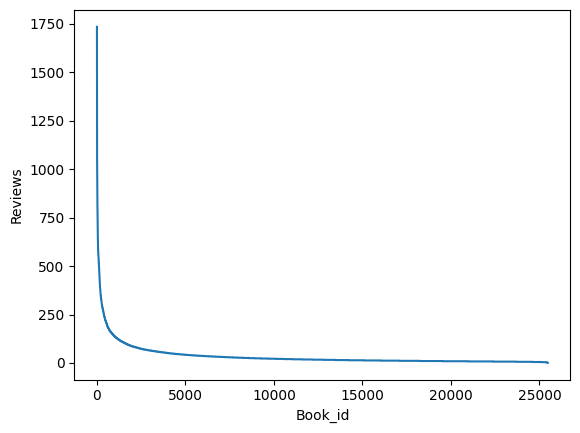

In [10]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

# too many reviews for some books, they need some balancing
reviews_x_book = [x[1] for x in sorted(list(set([(x, y) for x, y in df[['book_id', 'n_review_per_book']].values])),
                                       key = lambda x: -x[1])]
                                       
plt.plot(reviews_x_book)
plt.ylabel('Reviews')
plt.xlabel('Book_id')
plt.show()

# Preprocessing: Part I

## Balancing reviews per book
Sampling reviews pertaining to books with too many reviews

In [11]:
#average number of reviews per book
average_rev = int(sum(reviews_x_book) / len(reviews_x_book) // 1)
average_rev

35

In [12]:
indexes_to_keep = df[df['n_review_per_book'] <= average_rev].index
index_sampled = df[df['n_review_per_book'] > average_rev].groupby('book_id').sample(average_rev, random_state = 42).index

new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

In [13]:
df = df.loc[new_indexes].reset_index(drop=True)
len(df)

501745

## Checking NaN

In [14]:
df.rating.isna().sum()

0

## Cleaning Text

In [15]:
#cleaning review_text col
df.review_text = df.review_text.swifter.apply(lambda x: clean_tokens(x))
df.head()

Pandas Apply:   0%|          | 0/501745 [00:00<?, ?it/s]

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre,n_review_per_book
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,this is a special book. it started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,Science Fiction,20
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,recommended by don katz. avail for free in dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0,Classics,54
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"a fun, fast paced science fiction thriller. i ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0,Science Fiction,34
3,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"i really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1,Science Fiction,9
4,8842281e1d1347389f2ab93d60773d4d,19398490,ea4a220b10e6b5c796dae0e3b970aff1,4,a beautiful story. it is rare to encounter a b...,Sun Jan 03 21:20:46 -0800 2016,Tue Sep 20 23:30:15 -0700 2016,Tue Sep 13 11:51:51 -0700 2016,Sat Aug 20 07:03:03 -0700 2016,35,5,NaN,38


## Dropping duplicated reviews and some self-referencing reviews 

There are outlier reviews (some spam or other stuf) when there is a referens to review or reviews

In [16]:
idx_duplicated = df.loc[df.review_text.duplicated()].index
print(f'Duplicates removed: {len(idx_duplicated)}')
df.drop(index = idx_duplicated, inplace = True)

Duplicates removed: 7335


In [17]:
idx_selfref = [(idx) for idx, row in df.iterrows() if ('review' in row.review_text)]
print(f'Self-referencing reviews removed: {len(idx_selfref)}')
df.drop(index = idx_selfref, inplace = True)

Self-referencing reviews removed: 94174


## Checking avg and max length of reviews

In [18]:
review_length = df.review_text.transform(len)

In [19]:
min_revlen = review_length.min()
min_revlen

0

In [20]:
mean_revlen = review_length.mean()
mean_revlen

867.9148177575231

In [21]:
median_revlen = review_length.median()
median_revlen

512.0

In [22]:
max_revlen = review_length.max()
max_revlen

15028

## Dropping too short and too long reviews
At least they should be contained between the 1th and 95th percentile

In [23]:
third_percentile = review_length.quantile(0.50)
third_percentile

512.0

In [24]:
ninetyfifth_percentile = review_length.quantile(0.90)
ninetyfifth_percentile

2140.0

In [25]:
greater_than_third = review_length.values > third_percentile
lower_than_last = review_length.values < ninetyfifth_percentile

In [26]:
indices = [df.index[x] for x in np.where(greater_than_third & lower_than_last)[0]]

In [27]:
df = df.loc[indices]
df_len = len(df)
print(f'New Dataset Length: {df_len}')

New Dataset Length: 159959


## Storing the new training set

In [28]:
rev_df = df[["review_text", "rating", "book_id"]]
del df

In [29]:
rev_df.head()

,review_text,rating,book_id
0,this is a special book. it started slow for ab...,5,18245960
4,a beautiful story. it is rare to encounter a b...,4,19398490
6,a beautiful story. neil gaiman is truly a uniq...,5,5577844
10,mark watney is a steelyeyed missile man. a man...,5,17315048
13,a hilarious romp through the known and unknown...,4,12953520


In [30]:
len(rev_df)

159959

## Plotting ratings distribution: Before Undersampling

In [31]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

In [32]:
rev_df.rating.value_counts()

4    58687
5    40282
3    38708
2    14835
1     4734
0     2713
Name: rating, dtype: int64

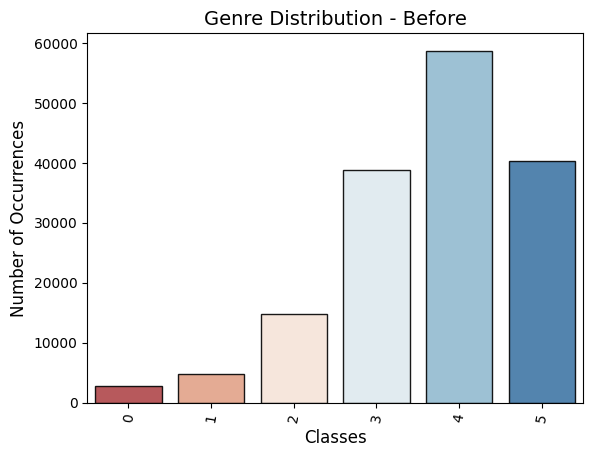

In [33]:
sns.barplot([x for x in rev_df.rating.value_counts().index],
            [y for y in rev_df.rating.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('rating Distribution - Before',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

## Class Undersampling

In [34]:
n = 2000
rating_w_more_than_n_reviews = rev_df.groupby('rating')['rating'].transform(len) >= n
#undersampling ratings with more than 2000 reviews to 2000
rev_df_reduced = pd.concat((rev_df[rating_w_more_than_n_reviews].groupby('rating').sample(n=n, random_state = 42), 
                            rev_df[~rating_w_more_than_n_reviews]), ignore_index=True)

## Plotting ratings distribution: After Undersampling

In [35]:
rev_df_reduced.rating.value_counts()

0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
Name: rating, dtype: int64

# Preprocessing: Part II

In [36]:
rev_df = rev_df_reduced
del rev_df_reduced

## Tokeninzing the Text

In [37]:
rev_df["tokenized_text"] = rev_df.review_text.swifter.apply(lambda x: word_tokenize(x))
rev_df.head()

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

,review_text,rating,book_id,tokenized_text
0,i saw a lot of people on booktube hauling this...,0,25062038,"[i, saw, a, lot, of, people, on, booktube, hau..."
1,i have done this several times on my blog. boo...,0,23245337,"[i, have, done, this, several, times, on, my, ..."
2,"wow, this one is an unexpected dnf for me. mad...",0,18189342,"[wow, ,, this, one, is, an, unexpected, dnf, f..."
3,"dnf at page . i really, really wanted to like ...",0,26153925,"[dnf, at, page, ., i, really, ,, really, wante..."
4,i've never been a big paranormal romance reade...,0,15989598,"[i, 've, never, been, a, big, paranormal, roma..."


## POS tagging

The Part Of Speech tag. Valid options are `"n"` for nouns, `"v"` for verbs, `"a"` for adjectives, `"r"` for adverbs and `"s"` for satellite adjectives.

In [38]:
rev_df["postagged_text"] = rev_df.tokenized_text.swifter.apply(lambda x: nltk.pos_tag(x))

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Dropping the tokenized text as we have an annotated version

In [39]:
rev_df.drop('tokenized_text', axis = 1, inplace = True)

In [40]:
list_of_tags = rev_df.postagged_text.swifter.apply(lambda x: [el[1] for el in x if len(el) == 2]).tolist()
set_of_tags = set()

for ls in list_of_tags:
    for tag in ls:
        set_of_tags.add(tag)

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

In [41]:
pos_mapper = {k : get_wordnet_pos(k) for k in set_of_tags}

In [42]:
list(pos_mapper.items())[:5]

[('CC', None), ('PRP$', None), ('CD', None), ('NNPS', 'n'), ('VBD', 'v')]

## Removing Stop Words

In [43]:
print(f"e.g. a token list len before: {len(rev_df.postagged_text[0])}")
rev_df["postagged_text"] = remove_stop_words(rev_df["postagged_text"], pos = True)
print(f"e.g. a token list len after: {len(rev_df.postagged_text[0])}")

e.g. a token list len before: 253
e.g. a token list len after: 80


## Filtering out short words

In [44]:
rev_df.head()

,review_text,rating,book_id,postagged_text
0,i saw a lot of people on booktube hauling this...,0,25062038,"[(saw, VBD), (lot, NN), (people, NNS), (booktu..."
1,i have done this several times on my blog. boo...,0,23245337,"[(times, NNS), (blog, NN), (books, NNS), (work..."
2,"wow, this one is an unexpected dnf for me. mad...",0,18189342,"[(wow, NN), (unexpected, JJ), (dnf, NN), (enjo..."
3,"dnf at page . i really, really wanted to like ...",0,26153925,"[(dnf, NN), (page, NN), (wanted, VBD), (like, ..."
4,i've never been a big paranormal romance reade...,0,15989598,"[(big, JJ), (paranormal, NN), (romance, NN), (..."


In [45]:
# minimum length of the remaining words of the fixed tokenized text 
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

1

In [46]:
#filtering the words with a length less than 2
rev_df["postagged_text"] = rev_df.postagged_text.map(lambda x: [el for el in x if len(el[0]) > 2])

Checking if both the tokenized text and the postagged one matches the new filtering

In [47]:
# minimum length of the remaining words of the fixed tokenized text after update
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

3

## Lemmatize the Tokens

In [48]:
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()
    
    for token, pos in row:
        if pos_mapper[pos] is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos_mapper[pos])

        lemmatized_row.append(lemma) # we discarded the pos here

    return lemmatized_row

In [49]:
#lemmatizing
rev_df['lemmatized_text'] = rev_df.postagged_text.swifter.apply(lambda x: lemmatize_row(x))

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

In [50]:
rev_df.drop('postagged_text', axis = 1, inplace = True)

In [51]:
rev_df.head()

,review_text,rating,book_id,lemmatized_text
0,i saw a lot of people on booktube hauling this...,0,25062038,"[saw, lot, people, booktube, haul, book, end, ..."
1,i have done this several times on my blog. boo...,0,23245337,"[time, blog, book, work, know, reading, style,..."
2,"wow, this one is an unexpected dnf for me. mad...",0,18189342,"[wow, unexpected, dnf, enjoy, author, book, to..."
3,"dnf at page . i really, really wanted to like ...",0,26153925,"[dnf, page, want, like, story, start, great, h..."
4,i've never been a big paranormal romance reade...,0,15989598,"[big, paranormal, romance, reader, premise, pa..."


# Saving the Training Set

In [52]:
rev_df.to_csv('./training_set_ratings.csv', index = False)

## Extracting Dictionary 

In [53]:
dict_count = dict(sorted(nltk.FreqDist([word for text in rev_df["lemmatized_text"] for word in text]).items(), 
                         key=lambda x: x[1], reverse=True))

In [54]:
list(dict_count.items())[:6]

[('book', 28839),
 ('like', 14676),
 ('read', 13834),
 ('story', 11120),
 ('character', 10699),
 ('love', 9917)]

In [55]:
# getting the max frequency of a word that appear in at most 80% of the review corpus 
maximum_threshold = np.quantile(list(dict_count.values()), 0.99)

In [56]:
# filtering out the extremes of the distribution
dict_count_fixed = {k:v for k,v in dict_count.items() if v > 5 and v < maximum_threshold}
# dict_count_fixed

In [57]:
dictionary = set(dict_count_fixed.keys())
# dictionary
len(dictionary)

10024

## Visualizations for the rating

In [58]:
# Instantiating the vectorizer
tfidf = TfidfVectorizer()

In [59]:
# joining the text back to a string
rev_df['lemmatized_joined'] = rev_df["lemmatized_text"].swifter.apply(lambda x: ' '.join(x))

# setting the corpus and the labels
corpus = rev_df["lemmatized_joined"]
labels = rev_df['rating']

# vectorizing
matrix = tfidf.fit_transform(corpus)

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

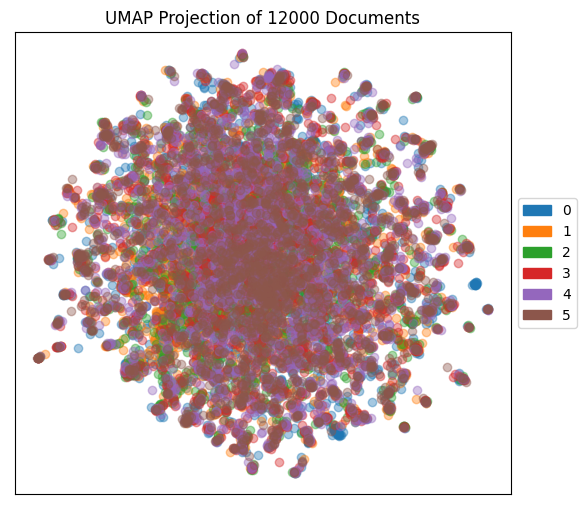

In [60]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
umap = UMAPVisualizer(ax = ax, alpha = 0.4)
umap.fit(matrix, labels, random_state = 42)
umap.show()

Regarding tSNE nothing of relevance appeared from the plot out of the fact that it seems there is some stronger internal connection with reviews related with Art and Thriller

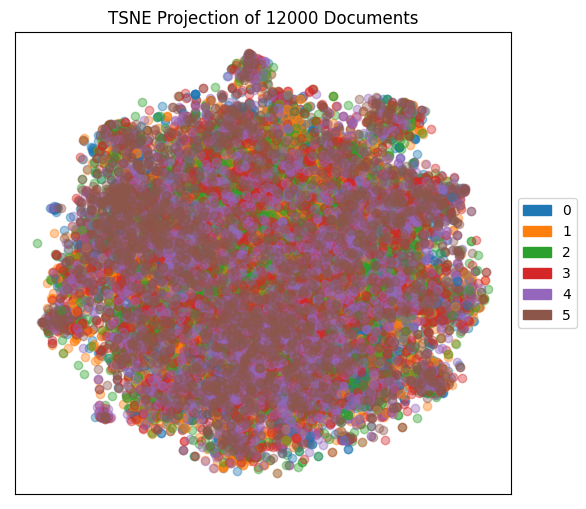

In [61]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
tsne = TSNEVisualizer(ax = ax, alpha = 0.4)
tsne.fit(matrix, labels, random_state = 42)
tsne.fit(matrix, labels, random_state = 42)
tsne.show()

## Topic Modeling

In [62]:
lemma_docs = rev_df["lemmatized_text"].values.tolist()

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(lemma_docs, min_count=20)

for idx in range(len(lemma_docs)):
    for token in bigram[lemma_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            # I keep both single words and bigrams in the document
            lemma_docs[idx].append(token)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [63]:
alternative_dictionary = Dictionary(lemma_docs)
print('Before Removal', len(alternative_dictionary))
# Filter out words that occur less than 5 documents, or more than 70% of the documents.
alternative_dictionary.filter_extremes(no_below=5, no_above=0.70)
print('After Filtering', len(alternative_dictionary))
not_filter = set(alternative_dictionary.values()).intersection(dictionary)
not_filter_idx = [alternative_dictionary.token2id[token] for token in not_filter]
alternative_dictionary.filter_tokens(good_ids=not_filter_idx)
print('After Intersection', len(alternative_dictionary))

Before Removal 42245
After Filtering 10834
After Intersection 9352


In [64]:
# Bag-of-words representation of the documents.
corpus = [alternative_dictionary.doc2bow(doc) for doc in lemma_docs]

In [65]:
for key, idxinfo in zip([alternative_dictionary[w[0]] for w in corpus[5]], corpus[5]):
    print (key, idxinfo)

ability (99, 2)
amazon (100, 1)
bestseller (101, 1)
browse (102, 1)
choose (103, 1)
circuit (104, 1)
circumstance (105, 1)
concentrate (106, 1)
copy (107, 1)
davidson (108, 1)
dedicate (109, 1)
dependent (110, 1)
external (111, 1)
happiness (112, 2)
inside (113, 1)
introduction (114, 1)
james (115, 1)
joy (116, 2)
observe (117, 1)
publish (118, 1)
quiet (119, 1)
quote (120, 2)
relieve (121, 1)
richard (122, 1)
september (123, 1)
stress (124, 2)
weapon (125, 1)
wellbeing (126, 1)
william (127, 1)


In [66]:
print(f'Number of unique tokens: {len(alternative_dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 9352
Number of documents: 12000


In [69]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = len(np.unique(rev_df['rating']))
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = alternative_dictionary[0]  # This is only to "load" the dictionary.
id2word = alternative_dictionary.id2token

model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes,
                 eval_every=eval_every
                 )

In [70]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print(f'Average topic coherence: {avg_topic_coherence:.4f}.')

Average topic coherence: -9.3117.


I see some words which appear in a lot of books going to the same topic, while I can recognize some thriller and romance -like words...

In [71]:
topic_clust_words = list()
cluster = 0

for topic in top_topics:
    print('\n', topic[1], [w[1] for w in topic[0]])
    representative_word = [w[1] for w in topic[0]][0]
    cluster += 1
    topic_clust_words.append((cluster, representative_word))


 -3.5529852252644907 ['trilogy', 'language', 'narrative', 'certainly', 'library', 'pace', 'group', 'society', 'describe', 'unique', 'intrigue', 'base', 'sentence', 'excellent', 'level', 'strange', 'horror', 'journey', 'travel', 'science']

 -3.876628773432678 ['sam', 'hurt', 'kiss', 'boyfriend', 'tear', 'date', 'jake', 'cry', 'angst', 'marry', 'sexual', 'gay', 'chemistry', 'pain', 'mom', 'shit', 'abuse', 'control', 'adam', 'wow']

 -9.12774104480707 ['fairy', 'jane', 'dragon', 'peter', 'werewolf', 'quinn', 'urban', 'beauty', 'princess', 'aunt', 'humor', 'paranormal', 'retelling', 'fairytale', 'demon', 'beast', 'zombie', 'amy', 'prince', 'kingdom']

 -12.239226514731387 ['henry', 'lily', 'emma', 'rise', 'thomas', 'favourite', 'luke', 'ghost', 'joe', 'queen', 'seat', 'danny', 'witch', 'john', 'richard', 'anita', 'city', 'connor', 'edge', 'cal']

 -12.56366571880938 ['harry', 'killer', 'demon', 'lucy', 'claire', 'detective', 'maggie', 'baby', 'ryan', 'grace', 'rape', 'tom', 'potter', 'ju

### Get insight on the ratings with topic words

In [72]:
topic_clust_words

[(1, 'trilogy'),
 (2, 'sam'),
 (3, 'fairy'),
 (4, 'henry'),
 (5, 'harry'),
 (6, 'volume')]

In [82]:
def frequency_per_rating(df, rating, avoid_first = 20):
    df_review = df[df.rating == rating]
    
    dict_count = dict(sorted(nltk.FreqDist([word for text in df_review["lemmatized_text"] for word in text]).items(), 
                             key=lambda x: x[1], reverse=True)[avoid_first:])
    
    return dict_count

In [83]:
from tqdm import tqdm

cluster_assignment = list()

for rating in tqdm(rev_df['rating'].unique()):
    for cluster, topic_word in topic_clust_words:
        try:
            freq = frequency_per_rating(rev_df, rating)[topic_word]
        except:
            freq = 0
        cluster_assignment.append((cluster, rating, topic_word, freq))

100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Extracting for each word and rating pair the frequency of the word in the reviews of that rating, then extracting the maximum frequency for each rating

In [84]:
topic_clust_assignment = pd.DataFrame(cluster_assignment, columns = ['cluster', 'rating', 'topic_word', 'freq'])
max_freq_of_rating = topic_clust_assignment[['rating', 'freq']].groupby('rating').max().reset_index()
max_freq_of_rating = max_freq_of_rating.merge(topic_clust_assignment, on=['rating', 'freq'])

In [86]:
max_freq_of_rating.head(10)

,rating,freq,cluster,topic_word
0,0,58,1,trilogy
1,1,43,5,harry
2,2,49,1,trilogy
3,3,63,3,fairy
4,3,63,6,volume
5,4,74,6,volume
6,5,85,1,trilogy


## WorldCloud

In [94]:
def generate_wordcloud_rating(df, rating, avoid_first = 20):
    f = frequency_per_rating(df, rating, avoid_first)
    mask = np.array(Image.open(str(rating) + ".png"))
    wc = WordCloud(background_color="white", 
                   max_words=200, max_font_size=100, 
                   random_state=42, mask = mask).generate_from_frequencies(f)
    plt.figure(figsize=(20,6))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(rating)
    plt.axis("off")
    plt.show()

In [96]:
import urllib.request

# Downloading pictures for word clouds
_0_url = 'https://www.shutterstock.com/image-illustration/3d-golden-number-collection-0-600w-140653882.jpg'
_1_url = 'https://www.shutterstock.com/image-illustration/3d-golden-number-collection-1-600w-140653867.jpg'
_2_url = 'https://st.depositphotos.com/1001311/3411/i/950/depositphotos_34119793-stock-photo-3d-golden-number-collection-2.jpg'
_3_url = 'https://www.shutterstock.com/image-illustration/3d-golden-number-collection-3-600w-134408636.jpg'
_4_url = 'https://st.depositphotos.com/1001311/3411/i/600/depositphotos_34119703-stock-photo-3d-golden-number-collection-4.jpg'
_5_url = 'https://www.shutterstock.com/image-illustration/3d-golden-number-collection-5-600w-134408702.jpg'

rating_url = {0 : _0_url, 1 : _1_url, 
             2 : _2_url, 3 : _3_url, 
             4 : _4_url, 5 : _5_url}

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

for rating, url in rating_url.items():
    urllib.request.urlretrieve(url, str(rating) + '.png')

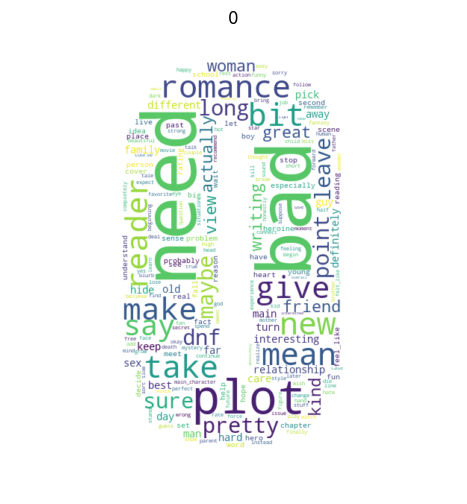

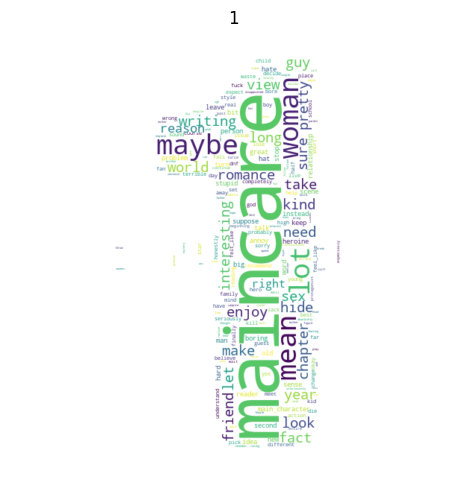

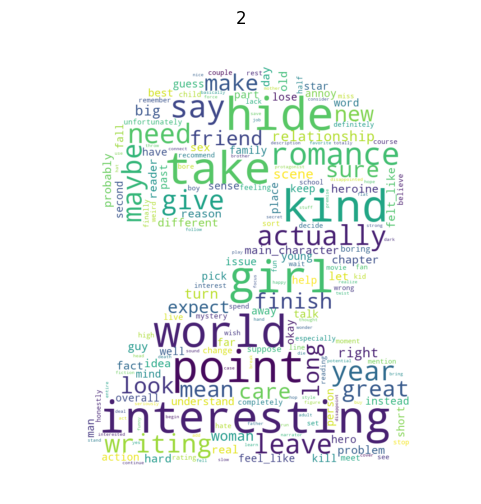

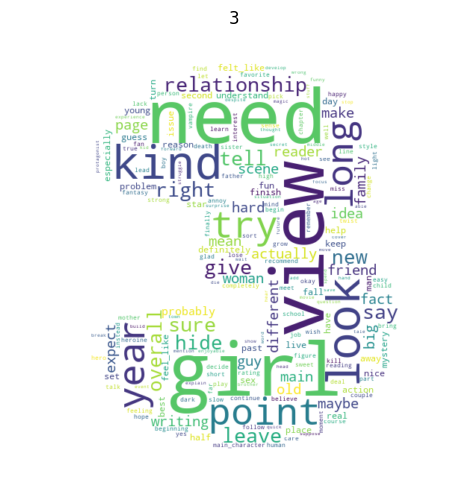

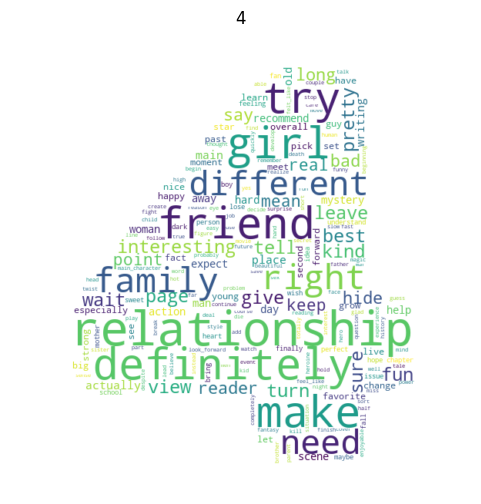

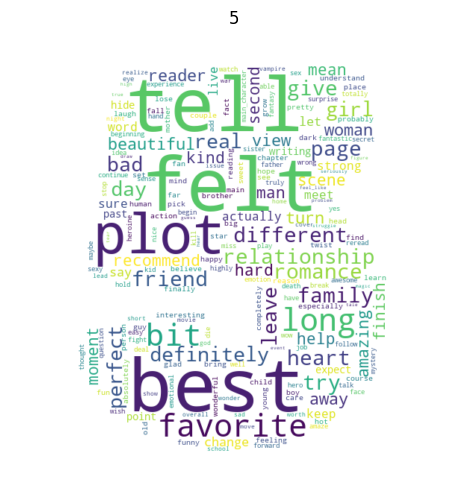

In [98]:
for rating in rating_url.keys():
    generate_wordcloud_rating(rev_df, rating, 40)

# BERT

In [101]:
# loading and preprocessing the test set
test_df = pd.read_csv('gr_test_set.csv', usecols=['review_text', 'book_id']).dropna().reset_index(drop=True)
test_df['review_text'] = test_df.review_text.swifter.apply(lambda x: clean_tokens(x))

print(f'Number of Rows: {len(test_df)}')

Pandas Apply:   0%|          | 0/478033 [00:00<?, ?it/s]

Number of Rows: 478033


In [102]:
from IPython.display import clear_output

!pip install transformers datasets evaluate
clear_output(wait=True)
print()

In [104]:
from datasets import Dataset, DatasetDict, Value, Features, ClassLabel
import numpy as np

train_df = rev_df[['review_text', 'rating']]
class_names = list(set(train_df['rating']))
class_labels = ClassLabel(names=class_names)
features = Features({'text': Value('string'), 'label': class_labels})

training_df = train_df.rename(columns={"review_text": "text", "rating": "label"})
training_set = Dataset.from_pandas(training_df[['text','label']], preserve_index = False, features = features)
training_set

Dataset({
    features: ['text', 'label'],
    num_rows: 12000
})

In [105]:
# 70% train, 30% test + validation
training_set = training_set.train_test_split(test_size=0.3, seed = 42)
training_set

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8400
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3600
    })
})

In [108]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = training_set.map(tokenize_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [113]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", 
                                                           num_labels=len(set(training_set['train']['label'])))

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transfo

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/pytorch_model.bin
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Ber

In [109]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)['accuracy'], 
            "f1 weighted": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]}


In [114]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"output_dir", 
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [115]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 8400
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 6300
  Number of trainable parameters = 108314886
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss
